This notebook is for calculating and plotting attenuations for different temperature stages of a fridge to thermalize photons. Based on formulas from Matt Sarsby's QuTech blog post: https://blog.qutech.nl/2020/02/20/cooling-a-hot-photon-wind-part-1/

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

# Function Definitions & Constants

In [2]:
PLANCK_CONST = 4.13567e-15 # eV*s (NOT HBAR)
BOLTZ_CONST = 8.617e-5 # eV/K
ZERO_DEG = 273.15 # Kelvin
possible_attenuations = np.array([0, 3, 6, 10, 12, 13, 16, 20, 23, 26, 30])

In [3]:
def thermal_attenuation(f, T1, T2):
    """Attenuation required to thermalize photons at T1 to *almost* temperature T2.
    
    Based on Matt Sarsby's rule of thumb: that more attenuation improves things but with diminishing returns.
    
    Parameters:
    -----------
    f (float): Frequency considered (Hz). For low enough frequencies this function is flat
    T1 (float): Temperature of incoming photons (K)
    T2 (float): Temperature of attenuator thermalizing photons (K)
    
    Returns:
    --------
    a (float): Required attenuation, in logarithmic format.
    """
    hf = PLANCK_CONST * f
    return 10*np.log((np.exp(hf/(BOLTZ_CONST * T1)) - 1) / (np.exp(hf/(BOLTZ_CONST * T2)) - 1))/np.log(10)

def bose_einstein(f, T):
    return 1 / (np.exp(PLANCK_CONST * f / (BOLTZ_CONST * T)) - 1)

def photon_temp(f, attenuation, T1, T2):
    transmission = 10**(-abs(attenuation)/10)
    n = transmission * bose_einstein(f, T1) + (1 - transmission) * bose_einstein(f, T2)
    return PLANCK_CONST * f / (BOLTZ_CONST * np.log((n + 1) / n))

def photon_temp_ideal(f, T1, T2):
    ideal_attenuation = thermal_attenuation(f, T1, T2)
    return photon_temp(f, ideal_attenuation, T1, T2)

def photon_temperatures(freq, temp_stages, attenuators, verbose=True):
    if len(attenuators) + 1 != len(temp_stages):
        raise Exception("There must be one less attenuator than temperature stage!")
    real_temps = [temp_stages[0], ]
    verbose_descriptions = []
    for i, att in enumerate(attenuators):
        current_photon_temp = photon_temp(freq, att, real_temps[i], temp_stages[i+1])
        real_temps.append(current_photon_temp)
        verbose_descriptions.append(
            f"Attenuation {att}dB at {temp_stages[i+1]}K takes {float(real_temps[i]):.3f}K photons to {current_photon_temp:.3f}K."
        )
    if verbose:
        pprint.pprint(verbose_descriptions)
    return real_temps

def ideal_photon_temperatures(freq, temp_stages, verbose=True):
    real_temps = [temp_stages[0], ]
    verbose_descriptions = []
    attenuators = []
    for i in range(len(temp_stages) - 1):
        attenuators.append(thermal_attenuation(freq, real_temps[i], temp_stages[i+1]))
        current_photon_temp = photon_temp(freq, attenuators[i], real_temps[i], temp_stages[i+1])
        real_temps.append(current_photon_temp)
        verbose_descriptions.append(
            f"Ideal attenuation {attenuators[i]:.1f}dB at {temp_stages[i+1]} takes {float(real_temps[i]):.3f}K photons to {current_photon_temp:.3f}K."
        )
    if verbose:
        pprint.pprint(verbose_descriptions)
    return real_temps, attenuators

## Plotting Required attenuation vs. frequency at different stages

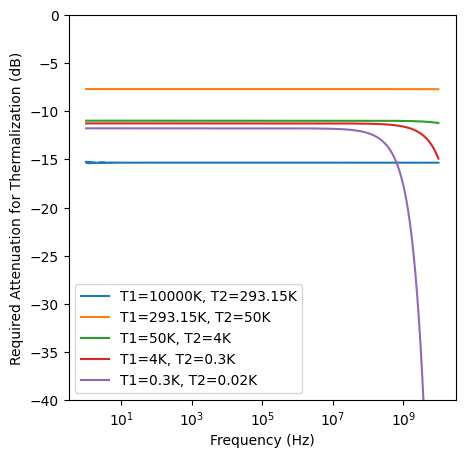

In [4]:
fig, ax = plt.subplots(figsize=(5,5))

temp_stages = [10000, ZERO_DEG + 20, 50, 4, 0.3, 0.02]
freqs = np.logspace(0, 10, 1001)

for i in range(len(temp_stages) - 1):
    ax.semilogx(freqs, thermal_attenuation(freqs, temp_stages[i], temp_stages[i+1]))
ax.set_ylim([-40,0])
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Required Attenuation for Thermalization (dB)")
ax.legend([f"T1={temp_stages[i]}K, T2={temp_stages[i+1]}K" for i in range(len(temp_stages)-1)])

## Plotting Photon Temperatures vs. Attenuation

ideal att: -14.771209935167715dB
ideal att: -6.916707722920313dB
ideal att: -18.56513949138888dB
ideal att: -9.969682326095572dB
Required attenuation at each stage:
['300K-10K: -14.771209935167715dB', '10K-4K: -6.916707722920313dB', '4K-0.1K: -18.56513949138888dB', '0.1K-0.02K: -9.969682326095572dB']
Total estimated attenuation required: -50.222739475572475dB


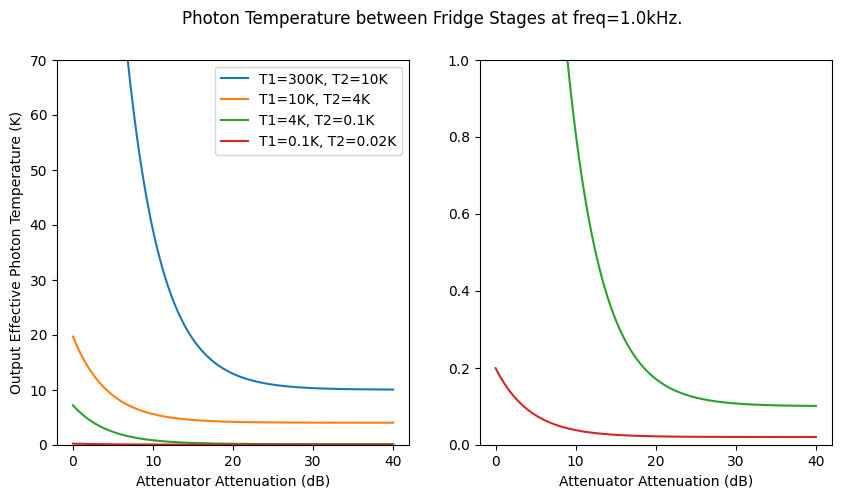

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# temp_stages = [10_000, ZERO_DEG + 20, 50, 4, 0.3, 0.02]
temp_stages = [300, 10, 4, 0.1, 0.02]
attenuations = np.linspace(0, 40, 1001)
ideal_attenuations = []
real_attenuations = []
freq = 1e3
previous_photon_temp = temp_stages[0]
for i in range(len(temp_stages) - 1):
    current_photon_temp = photon_temp(freq, attenuations, previous_photon_temp, temp_stages[i+1])
    axs[0].plot(attenuations, current_photon_temp, '-')
    axs[1].plot(attenuations, current_photon_temp, '-')
    ideal_attenuations.append(thermal_attenuation(freq, previous_photon_temp, temp_stages[i+1]))
    print(f"ideal att: {ideal_attenuations[i]}dB")
#     dists_to_real_atts = np.abs(possible_attenuations - ideal_attenuations[i])
#     closest_indices = np.argsort(dists_to_real_atts)
#     real_attenuations.append(max([possible_attenuations[closest_indices[0]], possible_attenuations[closest_indices[1]]]))
    previous_photon_temp = photon_temp_ideal(freq, previous_photon_temp, temp_stages[i+1])
axs[0].set_ylim([0, 70])
axs[1].set_ylim([0,1])
axs[0].set_xlabel("Attenuator Attenuation (dB)")
axs[1].set_xlabel("Attenuator Attenuation (dB)")
axs[0].set_ylabel("Output Effective Photon Temperature (K)")
axs[0].legend([f"T1={temp_stages[i]}K, T2={temp_stages[i+1]}K" for i in range(len(temp_stages)-1)])
fig.suptitle(f"Photon Temperature between Fridge Stages at freq={freq/1000}kHz.")
print("Required attenuation at each stage:")
print(list([f"{temp_stages[i]}K-{temp_stages[i+1]}K: {ideal_attenuations[i]}dB" for i in range(len(temp_stages)-1)]))
print(f"Total estimated attenuation required: {sum(ideal_attenuations)}dB")

# Checking Realistic Setups

In [24]:
# Given the temperature of each stage, and given the attenuators thermalizing stage 'i' to stage 'i+1', 
# Calculates the resulting photon temperature at each stage.

# 10_000K stage is estimated photon temperature output from electronic equipment
# temp_stages = [10_000, ZERO_DEG + 20, 67, 4, 0.77, 0.02] # Estimated temperatures inside/outside SG1
# temp_stages = [10_000, ZERO_DEG + 20, 50, 4, 0.8, 0.1, 0.02]
temp_stages = [300, 10, 4, 0.1, 0.02] # CF900
# attenuators = [6, 10, 20, 6, 30]
# attenuators = [10, 0, 20, 6, 6, 26] # K4/K5 RF lines
# attenuators = [20, 0, 0, 35] # CF900 readout
attenuators = [20, , 0] # CF900 fast gate line
freq = 1e3
print(f"Maximum possible power at sample level: {-10 - abs(sum(attenuators))}dBm")
real_temps = photon_temperatures(freq, temp_stages, attenuators, verbose=True)
ideal_temps, ideal_attenuators = ideal_photon_temperatures(freq, temp_stages, verbose=True)
print(f"Maximum possible power at sample level for ideal attenuations: {-10 - abs(sum(ideal_attenuators))}dBm")

Maximum possible power at sample level: -40dBm
['Attenuation 20dB at 10K takes 300.000K photons to 12.900K.',
 'Attenuation 0dB at 4K takes 12.900K photons to 12.900K.',
 'Attenuation 10dB at 0.1K takes 12.900K photons to 1.380K.',
 'Attenuation 0dB at 0.02K takes 1.380K photons to 1.380K.']
['Ideal attenuation -14.8dB at 10 takes 300.000K photons to 19.667K.',
 'Ideal attenuation -6.9dB at 4 takes 19.667K photons to 7.186K.',
 'Ideal attenuation -18.6dB at 0.1 takes 7.186K photons to 0.199K.',
 'Ideal attenuation -10.0dB at 0.02 takes 0.199K photons to 0.038K.']
Maximum possible power at sample level for ideal attenuations: -60.222739475572475dBm
